# Regression Model Building

 **Manual Feature Engineering for Regression Models**
* Lagged Features (Value from X Quarters ago)
* Rolling Window Features (Average Value of Feature over past X quarters)
* Time-Based Features (Year/Quarter)
* Trend Feature (No. of Observations)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

def macro_feature_engineering(df):
    df = df.copy()
    lags = [1, 2, 3, 4]
    features = ['hk_gdp_growth', 'us_gdp_growth', 'sti_close', 'sg_cpi',
                'iip', 'rsi', 'total_tourists', 'total_nodx', 'sg_gdp']
    
    for col in features:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    
    for col in features:
        df[f'{col}_qoq_pct'] = df[col].pct_change()

    for col in features:
        for w in [2, 4]:
            df[f'{col}_rollmean{w}'] = df[col].rolling(w).mean()
            df[f'{col}_rollstd{w}'] = df[col].rolling(w).std()
    
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df = pd.get_dummies(df, columns=['quarter'], drop_first=True)

    return df

Reading Data and Normalization

In [3]:
import pandas as pd

df = pd.read_csv(r"D:\PyTorch Projects\Malaysia_GDP\Code\MergedData.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df = macro_feature_engineering(df)
df.to_csv("RegressionFeatures.csv")
df.dropna(inplace=True)
X = df.drop(columns=['sg_gdp'])
y = df['sg_gdp']
X, y = X.align(y, join='inner', axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

     EVALUATION     
RMSE: 5076.591 | MAE: 4023.981 | MAPE: 3.17% | R²: 0.720 | Adjusted R²: 1.147 | Theil's U: 1.435



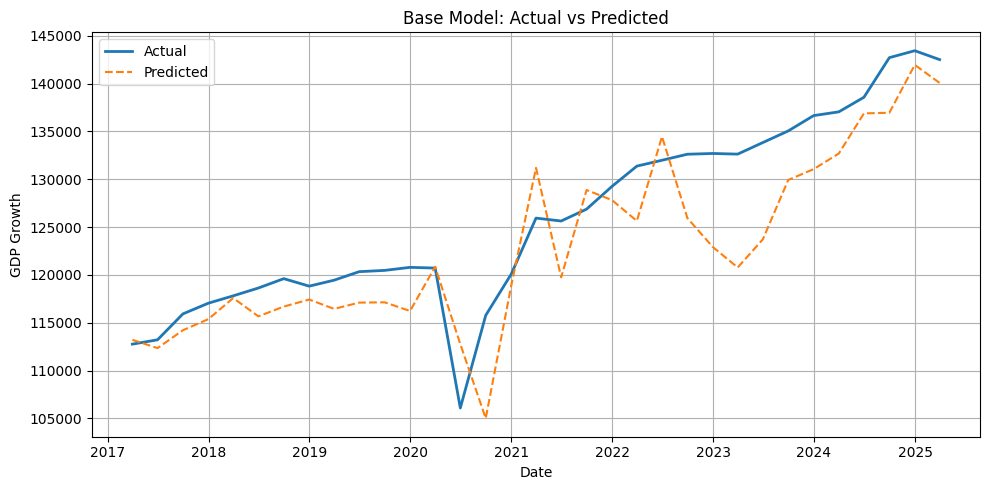

In [11]:
from sklearn.linear_model import LinearRegression   
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Model
base_model = LinearRegression()
base_model.fit(X_train_scaled, y_train)
y_pred = base_model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# Adjusted R²
n = X_test_scaled.shape[0]  # number of samples
k = X_test_scaled.shape[1]  # number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Convert y_pred to a Series with y_test's index
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Theil's U-statistic
def theils_u(actual, forecast):
    naive_forecast = actual.shift(1).dropna()
    actual = actual.iloc[1:]
    forecast = forecast.iloc[1:]

    rmse_model = np.sqrt(mean_squared_error(actual, forecast))
    rmse_naive = np.sqrt(mean_squared_error(actual, naive_forecast))

    return rmse_model / rmse_naive

# Compute Theil's U
u_stat = theils_u(y_test, y_pred_series)


print("====================")
print("     EVALUATION     ")
print("====================")
print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}% | R²: {r2:.3f} | Adjusted R²: {adj_r2:.3f} | Theil's U: {u_stat:.3f}\n")

# Plotting Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.title('Base Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('GDP Growth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

lasso_pipe = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=1, max_iter=5000))
lasso_pipe.fit(X, y)

lasso_model = lasso_pipe.named_steps['lassocv']
coef = lasso_model.coef_
selected_features = X.columns[coef != 0]
print("Selected Features:", list(selected_features))

X_selected = X[selected_features]

Selected Features: ['hk_gdp_growth', 'us_gdp_growth', 'rsi', 'us_gdp_growth_lag3', 'sti_close_lag4', 'sg_gdp_lag1', 'sg_gdp_lag2', 'sg_gdp_lag3', 'sg_gdp_lag4', 'hk_gdp_growth_qoq_pct', 'sti_close_qoq_pct', 'sg_gdp_qoq_pct', 'hk_gdp_growth_rollstd2', 'us_gdp_growth_rollmean2', 'sg_cpi_rollmean2', 'iip_rollstd2', 'iip_rollmean4', 'iip_rollstd4', 'rsi_rollstd2', 'total_tourists_rollstd2', 'total_tourists_rollstd4', 'sg_gdp_rollmean2']


In [8]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

pca = PCA(n_components=0.9)  # retains 95% variance
X_pca = pca.fit_transform(X_scaled)

print("Number of PCA components:", X_pca.shape[1])

Number of PCA components: 9


     EVALUATION     
RMSE: 5301.385 | MAE: 3881.112 | MAPE: 3.16% | R²: 0.694 | Adjusted R²: 1.160 | Theil's U: 1.485



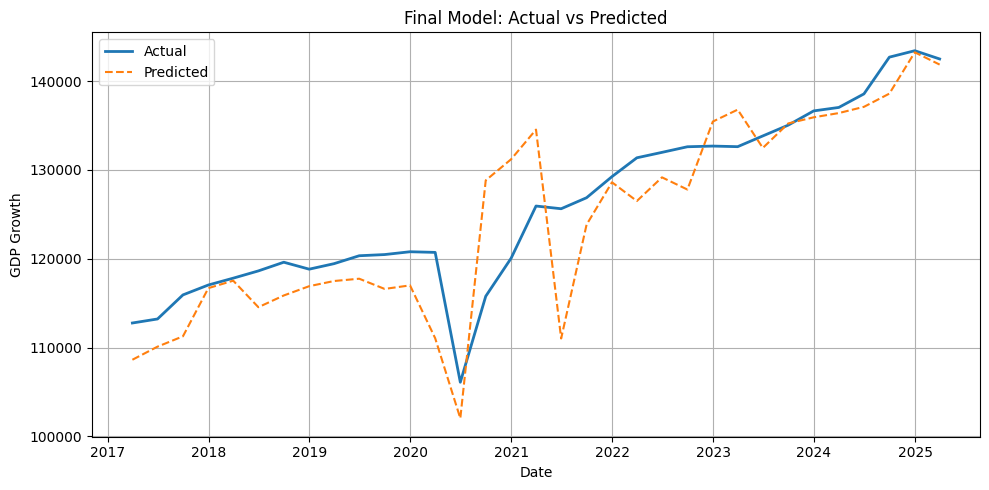

In [ ]:
X_final = X_pca
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_pca, y, train_size=0.7, shuffle=False)

final_model = LinearRegression()
final_model.fit(X_train_final, y_train_final)
y_pred_final = final_model.predict(X_test_final)

rmse = root_mean_squared_error(y_test_final, y_pred_final)
mae = mean_absolute_error(y_test_final, y_pred_final)
mape = np.mean(np.abs((y_test_final - y_pred_final) / y_test_final)) * 100
r2 = r2_score(y_test_final, y_pred_final)

# Adjusted R²
n = X_test_scaled.shape[0]  # number of samples
k = X_test_scaled.shape[1]  # number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Convert y_pred to a Series with y_test's index
y_pred_series = pd.Series(y_pred_final, index=y_test.index)

# Theil's U-statistic
def theils_u(actual, forecast):
    naive_forecast = actual.shift(1).dropna()
    actual = actual.iloc[1:]
    forecast = forecast.iloc[1:]

    rmse_model = np.sqrt(mean_squared_error(actual, forecast))
    rmse_naive = np.sqrt(mean_squared_error(actual, naive_forecast))

    return rmse_model / rmse_naive

u_stat = theils_u(y_test, y_pred_series)

print("====================")
print("     EVALUATION     ")
print("====================")
print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}% | R²: {r2:.3f} | Adjusted R²: {adj_r2:.3f} | Theil's U: {u_stat:.3f}\n")

# Prediction plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_final.index, y_test_final, label='Actual', linewidth=2)
plt.plot(y_test_final.index, y_pred_final, label='Predicted', linestyle='--')
plt.title('Final Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('GDP Growth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()